In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from functools import reduce
from src.utils import get_country_ts
from src.utils import get_high_mort

In [2]:
mpl.rcParams['figure.figsize'] = (9, 5)

# Goal
My goal is to visualize various aspect of the `COVID-19` pandemic.

# Data sources

In this project I use data from the following sources:
- https://github.com/CSSEGISandData/COVID-19 - JHU CSSE COVID-19 Data.
- [GDP per capita PPP](https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD) - The World Bank.
- [Population](https://data.worldbank.org/indicator/SP.POP.TOTL) - The World Bank.
- [Urban Population](https://data.worldbank.org/indicator/SP.URB.TOTL.IN.ZS) - The World Bank.
- [Population living in slums](https://data.worldbank.org/indicator/EN.POP.SLUM.UR.ZS) - The World Bank.
- [Rural population](https://data.worldbank.org/indicator/SP.RUR.TOTL.ZS) - The World Bank.
- [Life expectancy at birth](https://data.worldbank.org/indicator/SP.DYN.LE00.IN) - The World Bank.
- [Current healthcare expenditure](https://data.worldbank.org/indicator/SH.XPD.CHEX.GD.ZS) - The World Bank.
- https://datahub.io/JohnSnowLabs/country-and-continent-codes-list - country codes and continents.

# Data loading

In [3]:
conf = pd.read_csv('./data/cleaned/conf.csv')
recov = pd.read_csv('./data/cleaned/recov.csv')
dead = pd.read_csv('./data/cleaned/dead.csv')
active = pd.read_csv('./data/cleaned/active.csv')
mort = pd.read_csv('./data/cleaned/mort.csv')
coords = pd.read_csv('./data/cleaned/coords.csv')
ctry_to_cont = pd.read_csv('./data/cleaned/ctry_to_cont.csv')
country_stats = pd.read_csv('./data/cleaned/country_stats.csv')

In [4]:
dataframes = [conf, recov, dead, active]
names = ['Confirmed cases',
         'Recovered cases',
         'Fatal cases',
         'Active cases']

for name,df in zip(names, dataframes):
    df['Date'] = pd.to_datetime(df['Date'])
    
mort['Date'] = pd.to_datetime(mort['Date'])    

# COVID19 - Globally

First we plot the total number of cases around the world.

In [5]:
all_countries = sorted(set(coords['Country']))

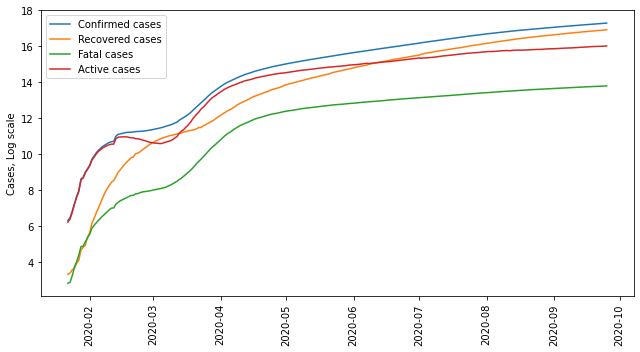

In [6]:
for name,df in zip(names, dataframes):
    plt.plot(df['Date'],
             np.log(df.drop('Date', axis=1).sum(axis=1)),
             label=name)
plt.ylabel('Cases, Log scale')
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# COVID19 - By continent

We drill down further into the data visualizing cases data at the continent level.

In [7]:
def continent_plot(df, name):
    """
    
    Plot cases over time by continent.
    
    """
    
    continents = set(ctry_to_cont['Continent'])
    for cont in continents:

        C = ctry_to_cont[ctry_to_cont['Continent'] == cont]
        C = C['Country'].to_list()

        plt.plot(df['Date'], df[C].sum(axis=1) / 10 ** 6, label=cont)

    plt.legend(loc='best')
    plt.title(f'{name}')
    plt.ylabel('Cases (mln)')
    plt.tight_layout()
    plt.show()    

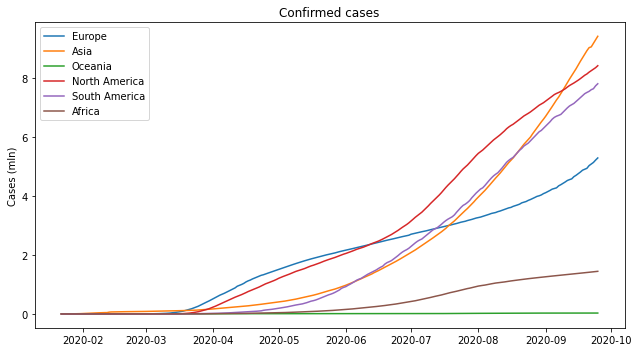

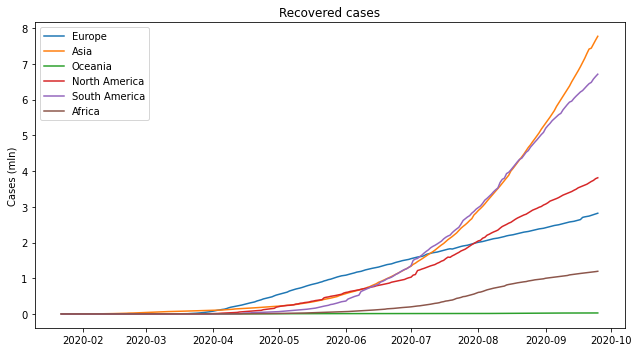

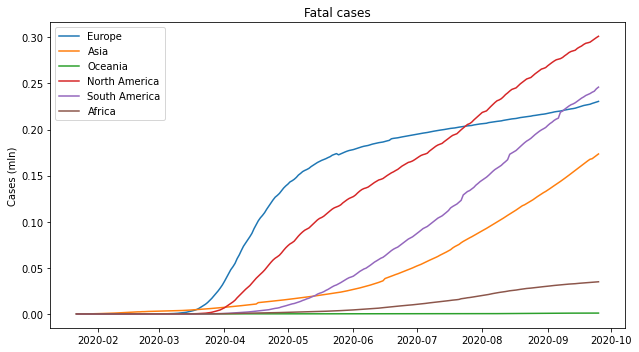

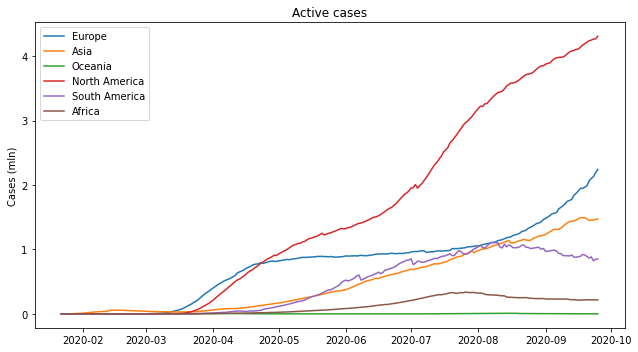

In [8]:
for name,df in zip(names, dataframes):
    continent_plot(df=df, name=name)  

# COVID - By country

Finally we can take a look at the data on a country level. First we show the countries with the most cases.

In [9]:
def most_cases(df, n=10):
    df = df.sum()
    df.name = name
    df = df.to_frame()
    df = df.sort_values(name, ascending=False)
    df = df.reset_index()
    df = df.rename(columns={'index': 'Country'})
    df = df.head(n)
    return df

In [10]:
def sorted_bar_plot(df, name, n=10):
    """
    
    Bar plot of countries with the most cases
    of a certain type.
    
    """
        
    df = most_cases(df=df)

    plt.bar(df['Country'], df[name])
    plt.xticks(rotation=90)
    plt.title(f'{name}')
    plt.ylabel('Cases, log scale')
    plt.tight_layout()
    plt.show()    

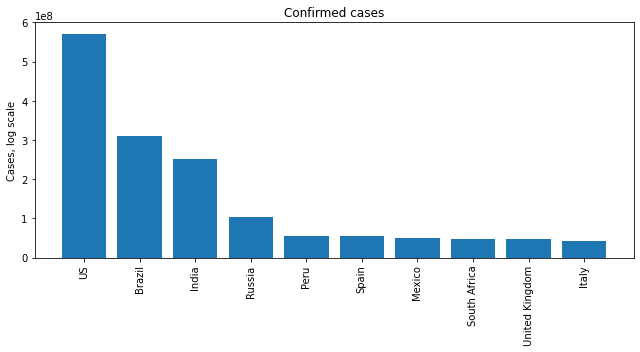

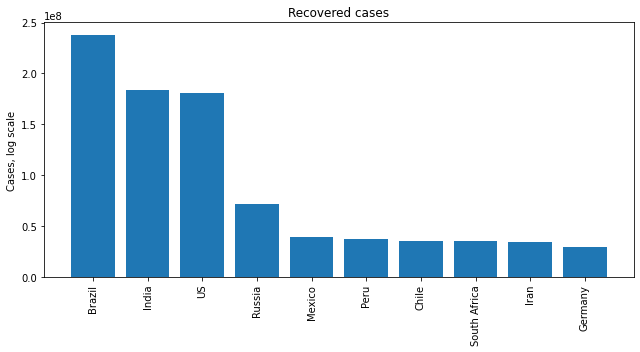

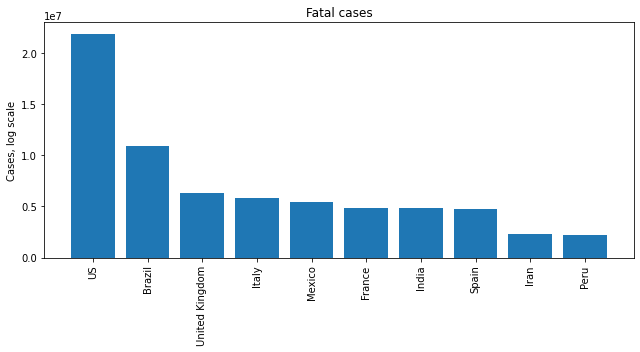

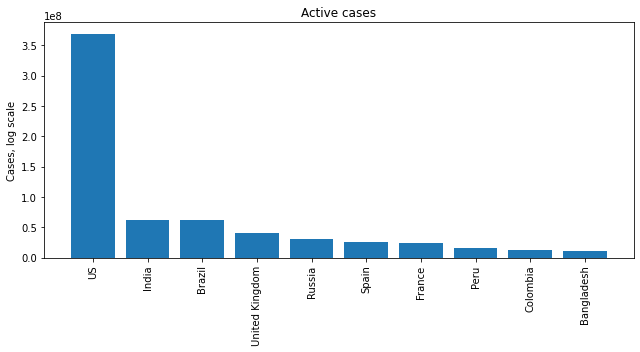

In [11]:
for name,df in zip(names, dataframes):
    sorted_bar_plot(df=df, name=name) 

Then we show countries with more than a thousand confirmed cases with the highest mortality rate.

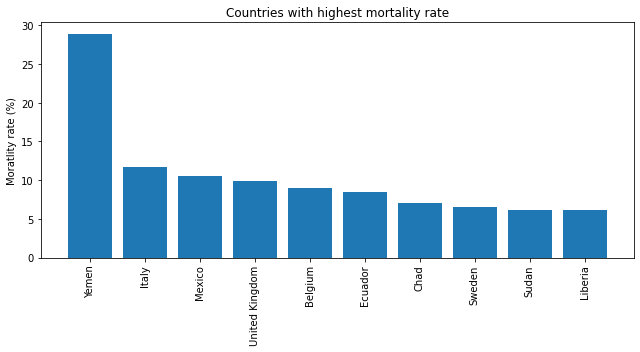

In [12]:
high_mort = get_high_mort(country_stats)

plt.bar(high_mort['Country'], height=high_mort['Mortality Rate'])
plt.xticks(rotation=90)
plt.ylabel('Moratlity rate (%)')
plt.title('Countries with highest mortality rate')
plt.tight_layout()
plt.show()

# COVID19 - Growth rates

We proceed to visualize the early days of the pandemic. In most cases the growth was exponential as will be seen.
First we define a function to calculate exponential growth. Secondly we create dataset of timeseries reindexed to begin at the point in time `t0` defined as the first day where a country reported more than a hundred confirmed cases. Then we plot the data.

In [13]:
def exp_growth(a, b, t, tau):
    """
    
    Calculate exponential growth.
    
    Parameters
    ----------
    a : int
        Initial value.
    b : int
        Growth factor.
    t : int 
        Time.
    tau : int
        Time required for increase by factor of b.
        
    Notes
    -----
    See https://en.wikipedia.org/wiki/Exponential_growth 
    for details.
    
    """
    
    return a * np.power(b, t / tau) 

In [14]:
conf_t0 = list()
for country in all_countries:
    t0 = get_country_ts(country=country, dataframes=[conf], columns=['Confirmed'])
    t0 = t0.loc[t0['Confirmed'] >= 100]
    t0 = t0.loc[:, ['Confirmed']]
    t0 = t0.reset_index(drop=True)
    conf_t0.append(t0)
    
conf_t0 = reduce(lambda x, y: pd.merge(x, y, left_index=True, 
                                       right_index=True, how='outer'), 
                 conf_t0)    
conf_t0.columns = all_countries
conf_t0 = conf_t0.head(100)
max_cases = max(conf_t0.max())

In [15]:
def growth_plot(df, countries, periods, steps=50):
    """
    
    Plot growth curves, log scale.
    
    Inputs
    ------
    df :
        `conf_t0` dataframe that contains confirmed
        cases reindexed to start with the date a 
        country had  >= 100 cases.
    countries : list
        List of countries
    periods : list of ints
        Doubling periods for growth curves.
    steps : int
        Number of data points to use.
    
    """
    
    countries = sorted(countries)
    
    # Extract mean and use as starting point for 
    # exponential growth curves.
    a = df.mean(axis=1)[0]
    b = 2

    # List of growth curves
    growth = list()
    for period in periods:
        g = exp_growth(a=a, 
                       b=b, 
                       t=np.arange(steps), 
                       tau=period)
        g = np.log(g)
        growth.append(list(g))

    for g,p in zip(growth, periods):

        # Draw growth curves
        plt.plot(range(steps), g, 
                 c='black', 
                 linestyle='dashed', 
                 alpha=1/2)

        if p == 1:
            s = f'Double every day'
        else:
            s = f'Double every {str(p)} days'       

        # Draw text outside
        plt.text(x=steps,
                 y=g[steps - 1],
                 s=s, 
                 alpha=3/4, 
                 horizontalalignment='left',
                 verticalalignment='center',
                 rotation_mode='anchor')

    # Draw country level data
    plot_df = conf_t0[countries].head(steps)
    for c in countries:
        plt.plot(range(len(plot_df)), np.log(plot_df[c]), label=c)

    plt.xlim(0, steps-1)
    plt.legend(loc='best')
    plt.ylabel('Confirmed cases, log scale')
    plt.xlabel('Days since 100 cases')
    plt.tight_layout()
    plt.show()

We plot the case growth curve against the countries with the most confirmed cases.

In [16]:
top5 = list(most_cases(df=conf, n=5)['Country'])
next5 = list(most_cases(df=conf, n=10)['Country'])[5:10]

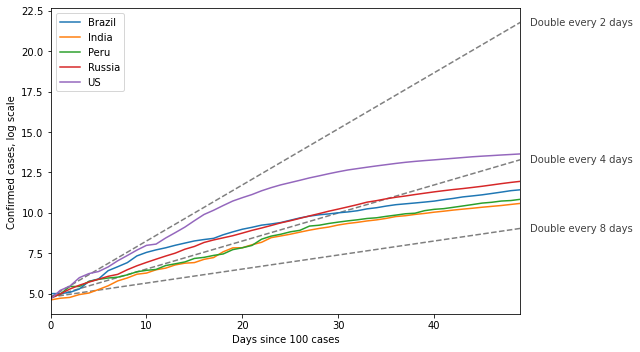

In [17]:
growth_plot(df=conf_t0, 
            countries=top5,
            periods=[2, 4, 8], 
            steps=50)

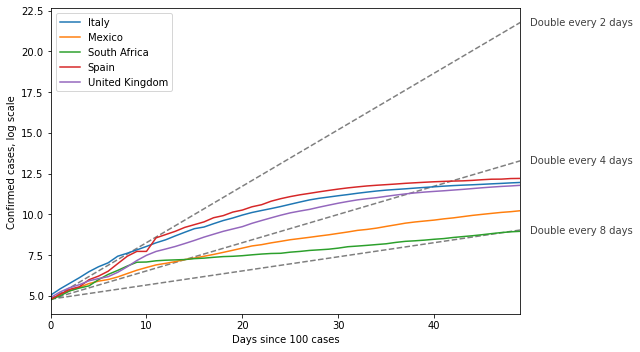

In [18]:
growth_plot(df=conf_t0, 
            countries=next5,
            periods=[2, 4, 8], 
            steps=50)

We plot the case growth curve against the countries with the highest mortality rates.

In [19]:
top5 = list(most_cases(df=mort, n=5)['Country'])
next5 = list(most_cases(df=mort, n=10)['Country'])[5:10]

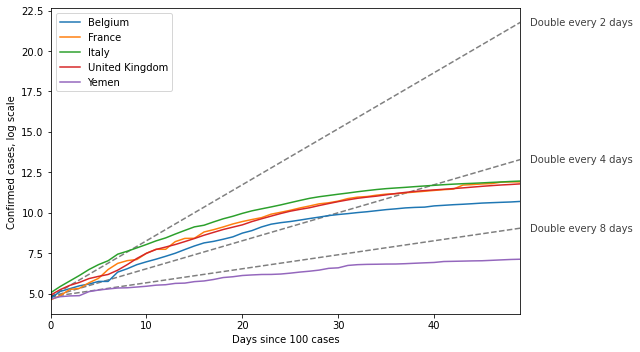

In [20]:
growth_plot(df=conf_t0, 
            countries=top5,
            periods=[2, 4, 8], 
            steps=50)

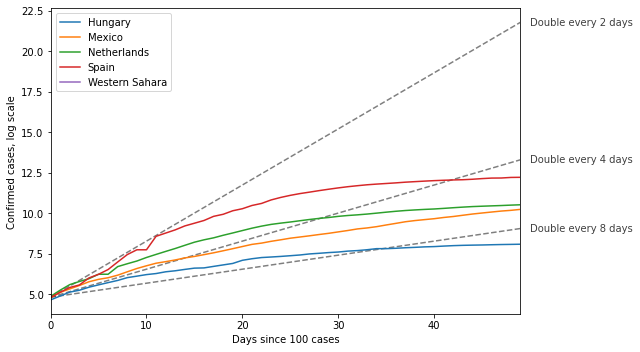

In [21]:
growth_plot(df=conf_t0, 
            countries=next5,
            periods=[2, 4, 8], 
            steps=50)